In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.7.1+cpu
torchvision version :  0.22.1+cpu
torchinfo version :  1.8.0
numpy version :  2.3.1
matplotlib version :  3.10.3
Python 3.11.4


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [4]:
data_dir =  os.path.join('dataset', 'data_undersampled', 'train')


print("Data Directory:", data_dir)

Data Directory: dataset\data_undersampled\train


In [5]:
classes = os.listdir(data_dir)


print("List of classes:", classes)

List of classes: ['Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease']


In [6]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [7]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.4326, 0.4953, 0.3120), 
                             std = (0.2178, 0.2214, 0.2091))
    ]
)

print(type(transform_normalized))
print("----------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
----------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.4326, 0.4953, 0.312), std=(0.2178, 0.2214, 0.2091))
)


In [8]:
normalized_dataset =  datasets.ImageFolder(root=data_dir, 
                                         transform=transform_normalized)



print('Length of dataset:', len(normalized_dataset))

Length of dataset: 5435


In [9]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(normalized_dataset, [0.8, 0.2], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

percent_train = np.round(100 * len(train_dataset) / len(normalized_dataset), 2)
percent_val = np.round(100 * len(val_dataset) / len(normalized_dataset), 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Length of training dataset: 4348
Length of validation dataset: 1087
Train data is 80.0% of full data
Validation data is 20.0% of full data


  0%|          | 0/4348 [00:00<?, ?it/s]

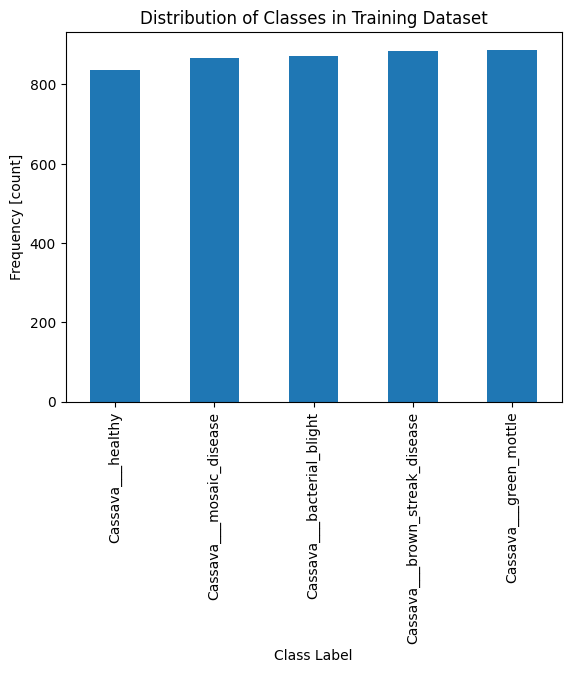

In [10]:
from training import class_counts

train_counts = class_counts(train_dataset)


# Make a bar chart from the function output
train_counts.sort_values().plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

  0%|          | 0/1087 [00:00<?, ?it/s]

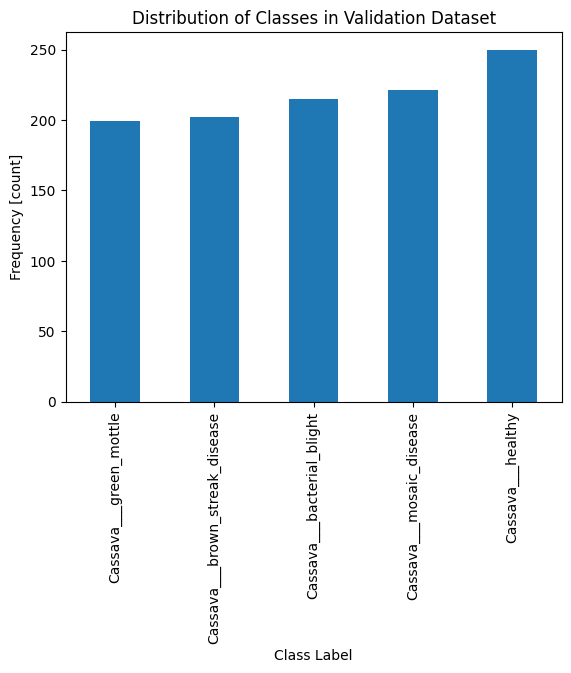

In [11]:
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.sort_values().plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

In [12]:
batch_size = 32

train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [13]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Freeze the models weights
for params in model.parameters():
    params.requires_grad = False
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
in_feat = model.fc.in_features

print(in_feat)

2048


In [16]:
modified_last_layer = nn.Sequential()

modified_last_layer.append(nn.Linear(in_feat, 256))

relu = nn.ReLU()
modified_last_layer.append(relu)

modified_last_layer.append(nn.Dropout(p=0.5))

linear = nn.Linear(256, 5)
modified_last_layer.append(linear)

model.fc = modified_last_layer

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [18]:
height = 224
width = 224

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [19]:
# Period of learning rate decay
step_size = 4
# Multiplicative factor of learning rate decay
gamma = 0.2

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [20]:
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    # Check if counter is >= patience (5 epochs in our case)
    # Set stop variable accordingly
    if counter >= 5:
        stop = True


    return counter, stop


early_stopping?

Signature: early_stopping(validation_loss, best_val_loss, counter)
Docstring: Function that implements Early Stopping
File:      c:\users\hp\appdata\local\temp\ipykernel_17684\1568996682.py
Type:      function

In [21]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

In [22]:
from training import score, train_epoch


def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [23]:
# epochs_to_train = 3

# train_results = train(
#     model,
#     optimizer,
#     loss_fn,
#     train_loader,
#     val_loader,
#     epochs=epochs_to_train,
#     device=device,
#     scheduler=scheduler,
#     checkpoint_path="model/LR_model.pth",
#     early_stopping=early_stopping,
# )

# (
#     learning_rates,
#     train_losses,
#     valid_losses,
#     train_accuracies,
#     valid_accuracies,
#     epochs,
# ) = train_results

In [24]:
epochs = 15
model = torch.load("model_trained.pth", weights_only=False)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

In [25]:
print(f"Training went on for {epochs} number of epochs before it stopped.")

Training went on for 15 number of epochs before it stopped.


In [27]:
import pandas as pd

eval_metrics_df = pd.read_csv("pretrained_model_evaluation_metrics.csv")
train_losses = eval_metrics_df['train_losses'].values
valid_losses = eval_metrics_df['valid_losses'].values
train_accuracies = eval_metrics_df['train_accuracies'].values
valid_accuracies = eval_metrics_df['valid_accuracies'].values
learning_rates = eval_metrics_df['learning_rates'].dropna().values

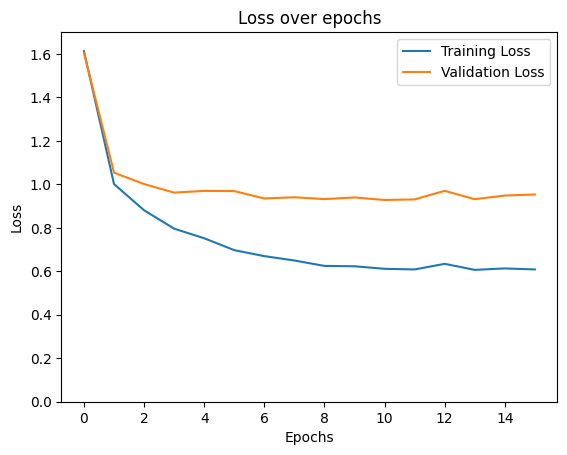

In [28]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

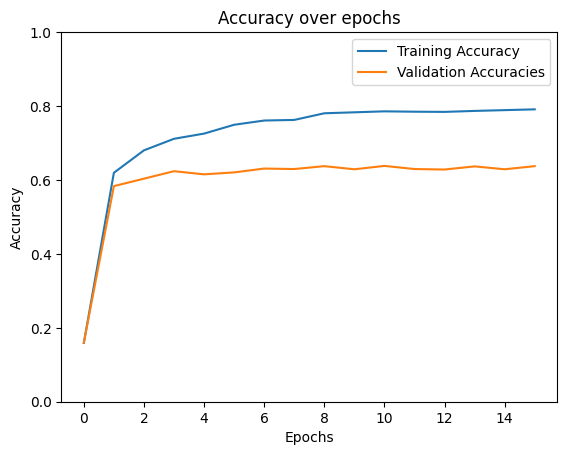

In [29]:
# Plot train accuracies, use label="Training Accuracy"
plt.plot(train_accuracies, label="Training Accuracy")
# Plot validation accuracies, use label="Validation Accuracy"
plt.plot(valid_accuracies, label="Validation Accuracies")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

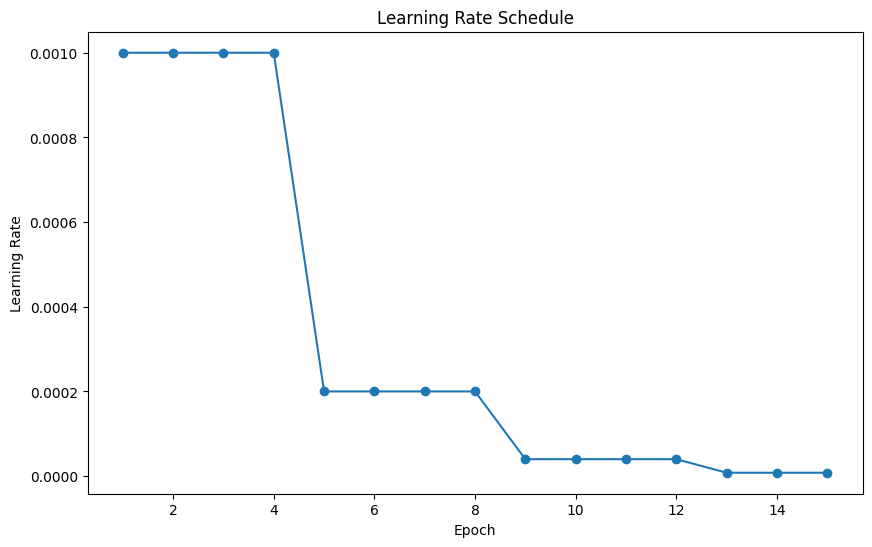

In [30]:
# Plot the learning rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [39]:
checkpoint = torch.load("model/LR_model.pth", map_location="cpu")
print(checkpoint.keys())  # look for extra info like 'arch' or 'model'

# model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])



dict_keys(['model_state_dict', 'optimizer_state_dict', 'loss'])


In [40]:
from training import predict

probabilities_val =  predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)


print(predictions_val)

Predicting:   0%|          | 0/34 [00:00<?, ?it/s]

tensor([4, 1, 1,  ..., 1, 2, 3])


Get Labels: 100%|██████████| 34/34 [00:13<00:00,  2.51it/s]


<Figure size 1000x800 with 0 Axes>

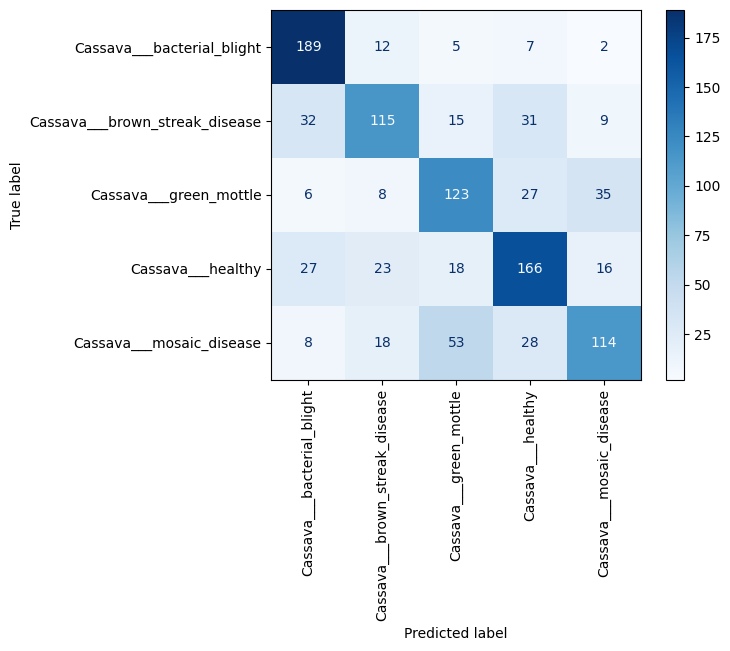

In [41]:
targets_val = torch.cat([labels for _, labels in tqdm(val_loader, desc="Get Labels")])

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

In [45]:
test_dir = os.path.join('dataset', 'test')

print(test_dir)

dataset\test


In [46]:
model.to(device)


def file_to_confidence(model, datadir, filename, transform_pipeline):
    file_path = os.path.join(datadir, filename)
    image = PIL.Image.open(file_path)
    transformed = transform_pipeline(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame([[filename] + confidence.tolist()[0]])
    conf_df.columns = ["ID"] + train_dataset.dataset.classes

    return conf_df

In [54]:
mosaic_train_dir = os.path.join("dataset", "Cassava___mosaic_disease")
mosaic_images = os.listdir(mosaic_train_dir)

file_to_confidence(model, mosaic_train_dir, mosaic_images[0], transform_normalized)

,ID,Cassava___bacterial_blight,Cassava___brown_streak_disease,Cassava___green_mottle,Cassava___healthy,Cassava___mosaic_disease
0,1007246985.jpg,2.563745e-08,1.010471e-07,0.846922,0.000233,0.152845


In [55]:
file_to_confidence(model, mosaic_train_dir, mosaic_images[1], transform_normalized)

,ID,Cassava___bacterial_blight,Cassava___brown_streak_disease,Cassava___green_mottle,Cassava___healthy,Cassava___mosaic_disease
0,1007533812.jpg,0.000401,0.073873,0.105614,0.016404,0.803709


In [57]:
small_dfs = []

for filename in tqdm(os.listdir(test_dir), desc="Predicting on test set"):
    small_dfs.append(
        file_to_confidence(model, test_dir, filename, transform_normalized)
    )

confidence_df = pd.concat(small_dfs)

confidence_df = confidence_df.sort_values("ID").reset_index(drop=True)
confidence_df.head()

Predicting on test set: 100%|██████████| 12/12 [00:00<00:00, 40.30it/s]


,ID,Cassava___bacterial_blight,Cassava___brown_streak_disease,Cassava___green_mottle,Cassava___healthy,Cassava___mosaic_disease
0,001.jpg,0.000230,0.192080,0.683458,0.029936,0.094297
1,002.jpg,0.381129,0.106235,0.000389,0.512105,0.000141
2,003.jpg,0.285435,0.005882,0.000044,0.708506,0.000133
3,004.jpg,0.001897,0.000865,0.679070,0.198256,0.119912
4,005.jpg,0.000026,0.000318,0.908379,0.024580,0.066697


In [58]:
confidence_df.to_csv("submission.csv", index=False)